In [ ]:
import torch
import torch.nn as nn

import numpy as np

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

# use for crossentropy classification because the output is a vector of probabilities that hardly can be compared with the target vector of labels when one-hot encoded makes these integers from 0 to 14 (15 classes)
LABEL_SMOOTHING = 0.015

: 

In [ ]:

from google.colab import drive

drive.mount("/content/drive", force_remount=True)
%cd '/content/drive/My Drive/Colab Notebooks/Labs/Computer Vision/CNN'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Labs/Computer Vision/CNN


In [ ]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.num_classes = num_classes

        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(0.1, inplace=True),
            #
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1, inplace=True),
            #
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1, inplace=True),
            #
            torch.nn.Flatten(),
            torch.nn.Linear(4096, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Dropout(0.5),
            #
            torch.nn.Linear(128, num_classes),
        )

    def forward(self, x):
        logits = self.layers(x)
        # probas = torch.softmax(logits, dim=1)
        return logits

Implement the CNN architecture and the training procedure. Then analyse the performance of the model by plotting accuracy and loss curves.

In [ ]:
# Default constants
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
MAX_EPOCHS = 10

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

trainset = dset.CIFAR10(
    "./data_CIFAR10",
    train=True,
    transform=transform,
    target_transform=None,
    download=False,
)
testset = dset.CIFAR10(
    "./data_CIFAR10",
    train=False,
    transform=transform,
    target_transform=None,
    download=False,
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# show some random training images
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.shape

torch.Size([32, 3, 32, 32])

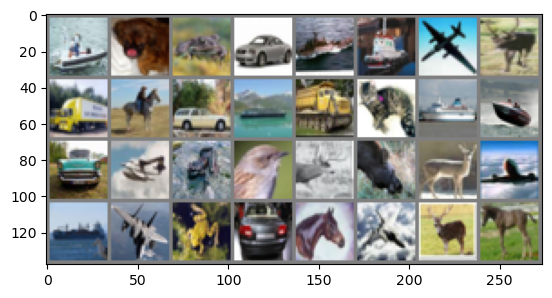

 ship       dog      frog       car      ship      ship     plane      deer     truck     horse       car      ship     truck       cat      ship      ship       car     plane      frog      bird      deer      deer      deer     plane      ship     plane      frog       car     horse     plane      deer     horse

trainloader lengh: 1563
dataiter lengh: 1563


In [ ]:
# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print("     ".join("%5s" % classes[labels[j]] for j in range(BATCH_SIZE)))
print()

print("trainloader lengh: " + str(len(trainloader)))
print("dataiter lengh: " + str(len(dataiter)))

In [ ]:
def accuracy(outputs, batch_y):
    """
    Computes the prediction accuracy, i.e., the average of correct predictions
    of the network.
    Args:
        predictions: 2D float array of size [number_of_data_samples, n_classes]
        labels: 2D int array of size [number_of_data_samples, n_classes] with one-hot encoding of ground-truth labels
    Returns:
        accuracy: scalar float, the accuracy of predictions.
    """

    _, predicted = torch.max(outputs.data, 1)
    total = batch_y.size(0)
    correct = (predicted == batch_y).sum().item()
    accuracy = 100.0 * correct / total

    return accuracy

In [ ]:
import tqdm


def train(cnn_model, optimizer):

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    cnn_model.to(DEVICE)
    cnn_model.train()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

    losses = []
    accuracies = []

    for epoch in range(MAX_EPOCHS):
        timestart = time.time()
        running_loss = 0.0
        for step, (batch_x, batch_y) in enumerate(tqdm.tqdm(trainloader), 0):

            # zero the parameter gradients
            optimizer.zero_grad()

            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

            outputs = cnn_model(batch_x)
            loss = criterion(outputs, batch_y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            losses.append(running_loss)

            accu = accuracy(outputs, batch_y)
            accuracies.append(accu)

        print("epoch %d cost %3f sec" % (epoch, time.time() - timestart))

    print("---Finished Training---")

    return losses, accuracies

In [ ]:
cnn_model = CNN()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

timestart = time.time()
losses, accuracies = train(cnn_model, optimizer)
total_time = time.time() - timestart

output_dir = "out_cnn"

100%|██████████| 1563/1563 [00:44<00:00, 34.98it/s]


epoch 0 cost 44.683506 sec


100%|██████████| 1563/1563 [01:24<00:00, 18.46it/s]


epoch 1 cost 84.660830 sec


100%|██████████| 1563/1563 [01:07<00:00, 23.08it/s]


epoch 2 cost 67.738391 sec


100%|██████████| 1563/1563 [03:06<00:00,  8.38it/s]  


epoch 3 cost 186.615273 sec


100%|██████████| 1563/1563 [00:54<00:00, 28.80it/s]


epoch 4 cost 54.280443 sec


100%|██████████| 1563/1563 [01:19<00:00, 19.60it/s]


epoch 5 cost 79.750122 sec


100%|██████████| 1563/1563 [01:38<00:00, 15.89it/s]


epoch 6 cost 98.383388 sec


100%|██████████| 1563/1563 [00:53<00:00, 29.29it/s]


epoch 7 cost 53.378976 sec


100%|██████████| 1563/1563 [01:54<00:00, 13.68it/s]


epoch 8 cost 114.289897 sec


100%|██████████| 1563/1563 [00:47<00:00, 32.72it/s]

epoch 9 cost 47.774763 sec
---Finished Training---


### Plot trainning metrics

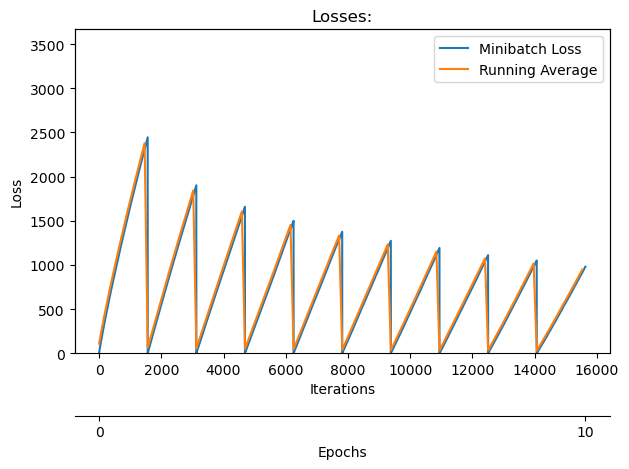

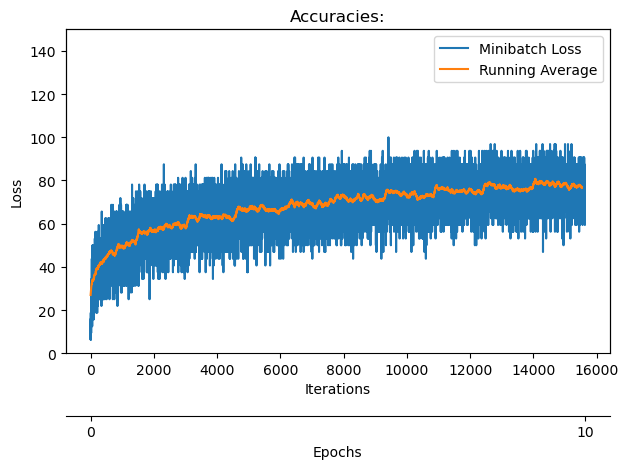

In [ ]:
from plot_helper import plot_training_loss

plot_training_loss(losses, MAX_EPOCHS, "Losses:")
plot_training_loss(accuracies, MAX_EPOCHS, "Accuracies:")

In [ ]:
def test(cnn):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.to(DEVICE)
    cnn.eval()
    test_accuracies = []

    for step, (batch_x, batch_y) in enumerate(tqdm.tqdm(testloader), 0):

        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

        outputs = cnn(batch_x)
        assert not torch.isnan(outputs).any()
        if step % 10 == 9:
            accu = accuracy(outputs, batch_y)
            test_accuracies.append(accu)
            print("Accuracy on the %d test images: %.3f %%" % (batch_y.size(0), accu))

    print("---Finished Testing---")
    return test_accuracies

In [ ]:
test_accuracies = test(cnn_model)

  8%|▊         | 25/313 [00:04<00:30,  9.41it/s]

Accuracy on the 32 test images: 81.250 %
Accuracy on the 32 test images: 84.375 %
Accuracy on the 32 test images: 84.375 %


 21%|██        | 65/313 [00:04<00:06, 37.82it/s]

Accuracy on the 32 test images: 71.875 %
Accuracy on the 32 test images: 68.750 %
Accuracy on the 32 test images: 71.875 %


 28%|██▊       | 89/313 [00:04<00:03, 58.55it/s]

Accuracy on the 32 test images: 68.750 %
Accuracy on the 32 test images: 65.625 %
Accuracy on the 32 test images: 81.250 %


 37%|███▋      | 116/313 [00:05<00:02, 81.77it/s]

Accuracy on the 32 test images: 65.625 %
Accuracy on the 32 test images: 59.375 %
Accuracy on the 32 test images: 71.875 %


 45%|████▍     | 140/313 [00:05<00:01, 91.71it/s]

Accuracy on the 32 test images: 75.000 %
Accuracy on the 32 test images: 71.875 %
Accuracy on the 32 test images: 75.000 %


 56%|█████▌    | 175/313 [00:05<00:01, 92.04it/s]

Accuracy on the 32 test images: 75.000 %
Accuracy on the 32 test images: 62.500 %


 63%|██████▎   | 196/313 [00:05<00:01, 95.26it/s]

Accuracy on the 32 test images: 71.875 %
Accuracy on the 32 test images: 62.500 %
Accuracy on the 32 test images: 62.500 %


 72%|███████▏  | 226/313 [00:06<00:00, 89.76it/s]

Accuracy on the 32 test images: 78.125 %
Accuracy on the 32 test images: 68.750 %


 78%|███████▊  | 245/313 [00:06<00:00, 84.42it/s]

Accuracy on the 32 test images: 90.625 %
Accuracy on the 32 test images: 81.250 %


 84%|████████▎ | 262/313 [00:06<00:00, 71.57it/s]

Accuracy on the 32 test images: 81.250 %
Accuracy on the 32 test images: 56.250 %


 90%|█████████ | 283/313 [00:06<00:00, 86.78it/s]

Accuracy on the 32 test images: 59.375 %
Accuracy on the 32 test images: 56.250 %
Accuracy on the 32 test images: 65.625 %


 98%|█████████▊| 308/313 [00:07<00:00, 102.98it/s]

Accuracy on the 32 test images: 78.125 %
Accuracy on the 32 test images: 62.500 %


100%|██████████| 313/313 [00:07<00:00, 41.68it/s] 

---Finished Testing---


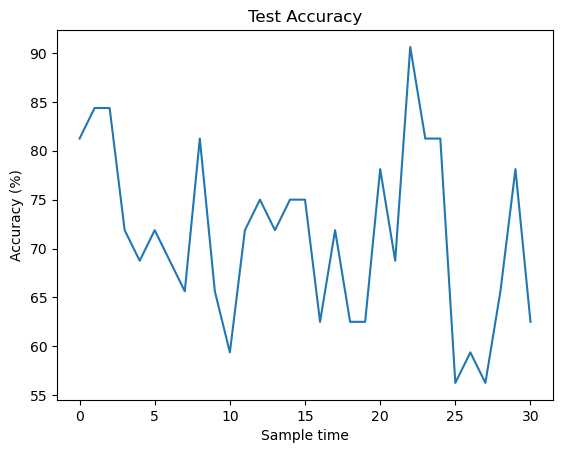

In [ ]:
plt.title("Test Accuracy")
plt.plot(test_accuracies)
plt.xlabel("Sample time")
plt.ylabel("Accuracy (%)")
plt.show()

Average test accuracy is : 71.27016129032258


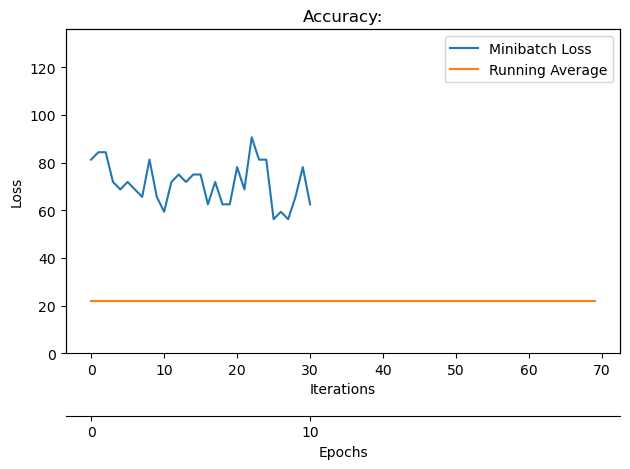

In [ ]:
avg_test_accuracy = np.mean(test_accuracies)
print("Average test accuracy is : " + str(avg_test_accuracy))

plot_training_loss(test_accuracies, MAX_EPOCHS, "Accuracy:")